In [3]:
#@title Obtain wavefront estimation from DL-AO network

####################################################################################################
##Script for testing DL-AO network in Google Colaboratory
##
##(C) Copyright 2022                The Huang Lab
##
##    All rights reserved           Weldon School of Biomedical Engineering
##                                  Purdue University
##                                  West Lafayette, Indiana
##                                  USA
##
##    Peiyi Zhang, Nov 2022
####################################################################################################

# import modules
import torch 
import torch.nn as nn
import torch.nn.parallel
import os
import sys
import scipy.io as sio
import numpy as np
from torch.autograd import Variable
import argparse
from tqdm import tqdm
import h5py
from google.colab import drive
torch.manual_seed(12)                                                                                          # Sets the seed for generating random numbers
torch.cuda.is_available()                                                                                      # verify if GPU is enabled (Output "True" indicates GPU is available now)
drive.mount('/content/drive')                                                                                  # connect Google Drive into Colab
basedir = '/content/drive/My Drive/DL-AO_Inference_Demo_Colab/'
os.chdir(basedir)                                                                                              # change directory
!pwd                                                                                                           # check current directory

execfile('opts.py')                                                                                            # executes the contents of opts.py
opt = options()                                                                                                # access the function in opts.py
opt.datapath = basedir + 'ExampleData/'                                                                        # set path for loading test data 
execfile('model.py')       
opt.datapath = basedir + 'ExampleData/'                                                                        # set path for loading test data 
opt.checkptname = 'Network2.pth';                                                                              # set name of pre-trained DL-AO network
model = torch.load(os.path.join(opt.datapath, opt.checkptname))                                                # Load the trained DL-AO network
model = model.module.to(device='cuda:0')                                                                       # Specify hardware
# Define functions
def loaddata(opt):                                                                                             # function definition
    mat_contents = h5py.File(os.path.join(opt.datapath, 'testdata.mat'),'r')                                   # read testdata file
    dataset = torch.from_numpy(np.array(mat_contents.get('imsp'))).float()                                     # load variable contains PSFs in test data
    if dataset.dim() < 4:                                                                                      # check test data format
        print('(Error) require 4D input. \Plese modify your input to be: imsz x imsz x nchannel x datasize')   # error message
        exit()

    print('test data size:', dataset.size(0), 'x', dataset.size(1), 'x', dataset.size(2), 'x', dataset.size(3))# print data dimension

    for i in range(dataset.size(0)):
        for j in range(opt.channel):
            dataset[i][j]=dataset[i][j]/torch.max(dataset[i][j])                                               # normalize sub-regions

    return dataset
  
def test(model, opt, data):
    count, totalErr, err = 0, 0, 0
    opt.datasize = data.size(0)                                                                                # number of sub-regions
    opt.imWidth = data.size(2)                                                                                 # image width of sub-regions
    opt.imHeight = data.size(3)                                                                                # image height of sub-regions
    if opt.datasize<opt.batchsize:
      opt.batchsize = opt.datasize                                                                             # batch size for testing
    x = torch.Tensor(opt.batchsize, opt.channel, opt.imWidth, opt.imHeight).cuda()                             # Tensor for loading sub-regions   
    model.eval()                                                                                               # set model in evaluation (inference) mode
    output = torch.Tensor()                                                                                    # Tensor for concatenating output
    with torch.no_grad():                                                                                      # deactivate autograd engine
        for i in tqdm(range(0, opt.datasize, opt.batchsize), ncols = 100, desc = "Testing (# of batches)"):    # loop through batches with progress bars
            for ii in range(opt.batchsize):                                                                    # loop sub-regions in one batch
                if (i+ii) > opt.datasize - 1:
                    break
                else:
                    x[ii] = data[i+ii]
            out = model.forward(x)                                                                             # forward propagation
            output = torch.cat([output, out.cpu()], 0)                                                         # concatenating outputs

    savepath = basedir + 'result/';                                                                            # path for saving results
    if not os.path.exists(savepath):
        os.makedirs(savepath)                                                                                  # create folder for saving results
    sio.savemat(os.path.join(savepath, 'result.mat'), {'aberration': output[0:opt.datasize].numpy()})          # save result
    print('\nresult saved at: ', savepath)

def main(model, opt):
    data = loaddata(opt)                                                                                       # Load testdata
    test(model, opt, data)                                                                                     # Test network

if __name__ == '__main__':
    main(model, opt)                                                                                                     # Execute main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DL-AO_Inference_Demo_Colab
test data size: 1000 x 2 x 32 x 32


Testing (# of batches): 100%|█████████████████████████████████████████| 8/8 [00:06<00:00,  1.27it/s]



result saved at:  /content/drive/My Drive/DL-AO_Inference_Demo_Colab/result/


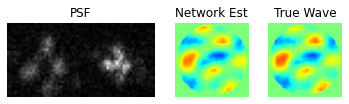

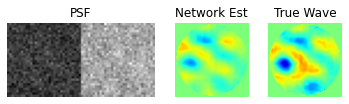

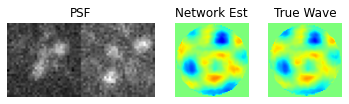

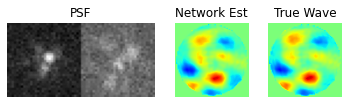

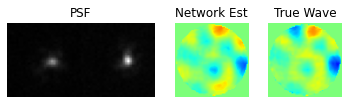


Continue? y/nn


In [4]:
#@title Display estimation result
# load Network Estimation result
savedir = '/content/drive/My Drive/DL-AO_Inference_Demo_Colab/result/'
mat_contents = sio.loadmat(os.path.join(savedir, 'result.mat'))
est = torch.from_numpy(mat_contents['aberration'].astype(float))

# load ground truth label
datadir = '/content/drive/My Drive/DL-AO_Inference_Demo_Colab/ExampleData/'
mat_contents2 = sio.loadmat(os.path.join(datadir, 'testlabel.mat'))
label = torch.from_numpy(mat_contents2['label'].astype(float))

# load measured wavefront basis
mat_contents3 = sio.loadmat(os.path.join(datadir, 'MirrorMode.mat'))
Mode = torch.from_numpy(mat_contents3['ExperimentalMirrorMode'].astype(float))
Mode = Mode[33:96, 33:96,:]

# load PSFs used for testing
mat_contents4 = h5py.File(os.path.join(datadir, 'testdata.mat'),'r')
PSFs = torch.from_numpy(np.array(mat_contents4.get('imsp'))).float()

# display data and estimation result
torch.manual_seed(12)
from matplotlib import pyplot as plt
import math
N = PSFs.size(0)
Ntype = 28
shuffle = torch.randperm(N)
flag = 'y'
for i in range(0, N):
  WaveEst = torch.zeros(Mode[:,:,1].size())
  WaveTrue = torch.zeros(Mode[:,:,1].size());
  for j in range(0, Ntype):
    WaveEst = WaveEst + est[shuffle[i],j]*Mode[:,:,j]
    WaveTrue = WaveTrue + label[shuffle[i],j]*Mode[:,:,j]
  f, (ax1, ax2, ax3) = plt.subplots(1, 3,  gridspec_kw={'width_ratios': [2, 1, 1]})
  subregion = torch.cat([PSFs[shuffle[i],0,:,:], PSFs[shuffle[i],1,:,:]], 1)
  ax1.imshow(subregion, cmap='gray')
  ax1.axis("off")
  ax1.set_title('PSF')
  ax2.imshow(WaveEst, cmap='jet', vmin = -math.pi, vmax = math.pi)
  ax2.axis("off")
  ax2.set_title('Network Est')
  ax3.imshow(WaveTrue, cmap='jet', vmin = -math.pi, vmax = math.pi)
  ax3.axis("off")
  ax3.set_title('True Wave')
  plt.pause(1)
  
  if math.remainder(i+1,5) == 0:
    flag = input("\nContinue? y/n")
    if flag == 'n':
      break